#Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Load Train & Test Data

In [3]:
train = pd.read_csv("train_hourly.csv", index_col=0)
test = pd.read_csv("test_hourly.csv", index_col=0)

train.index = pd.to_datetime(train.index, dayfirst=True, errors='coerce')
test.index = pd.to_datetime(test.index, dayfirst=True, errors='coerce')

target_column = "Global_active_power"

/tmp/ipython-input-2420277471.py:4: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  train.index = pd.to_datetime(train.index, dayfirst=True, errors='coerce')


#Creating LSTM Sequences

In [4]:
def create_sequences(data, target_col, seq_length=24):
    X, y = [], []
    values = data[target_col].values
    for i in range(seq_length, len(values)):
        X.append(values[i-seq_length:i])
        y.append(values[i])
    return np.array(X), np.array(y)

SEQ_LEN = 24  # past 24 hours

X_train, y_train = create_sequences(train, target_column, SEQ_LEN)
X_test, y_test = create_sequences(test, target_column, SEQ_LEN)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#building model

In [5]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

#train the lstm model

In [6]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0561 - val_loss: 0.0299
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0346 - val_loss: 0.0284
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0321 - val_loss: 0.0272
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0291 - val_loss: 0.0254
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0264 - val_loss: 0.0231
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0241 - val_loss: 0.0224
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0200 - val_loss: 0.0204
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0191 - val_loss: 0.0193
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0167 - val_loss: 0.0193
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0180 - val_loss: 0.0190
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

#Plot Training vs Validation Loss

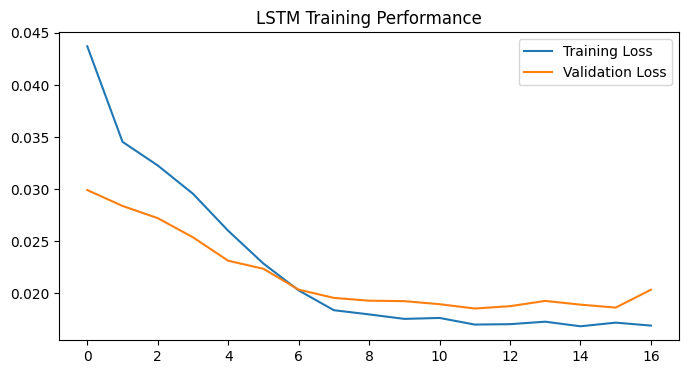

In [7]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("LSTM Training Performance")
plt.show()

#Make Predictions

In [8]:
lstm_predictions = model.predict(X_test).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


#Model Evaluation Metrics

In [9]:
mae = mean_absolute_error(y_test, lstm_predictions)
rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
r2 = r2_score(y_test, lstm_predictions)

print("LSTM Model Performance")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

LSTM Model Performance
MAE : 0.10264781658823614
RMSE: 0.13911729926202268
R²  : 0.5153734207977729


#Actual vs Predicted Plot

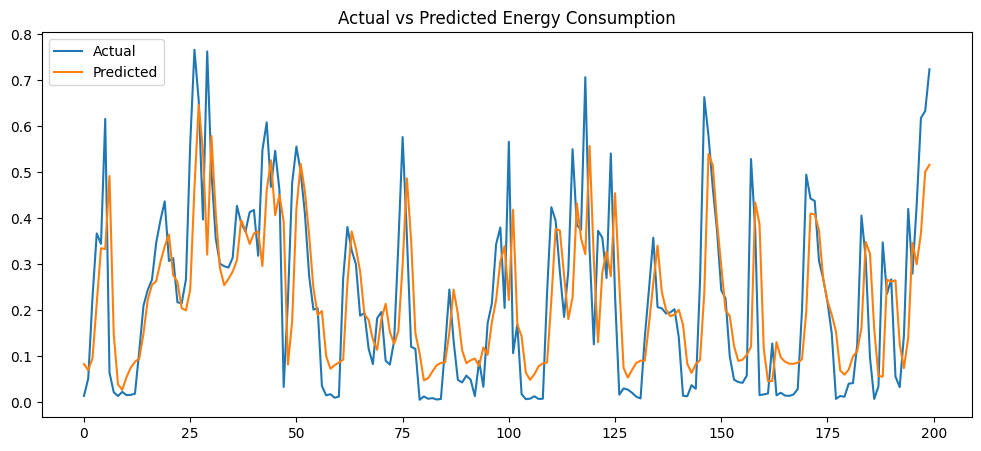

In [10]:
plt.figure(figsize=(12,5))
plt.plot(y_test[:200], label="Actual")
plt.plot(lstm_predictions[:200], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Energy Consumption")
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_lr = np.arange(len(train)).reshape(-1, 1)
y_train_lr = train[target_column].values

X_test_lr = np.arange(len(test)).reshape(-1, 1)
y_test_lr = test[target_column].values

lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

baseline_predictions = lr_model.predict(X_test_lr)

baseline_mae = mean_absolute_error(y_test_lr, baseline_predictions)
baseline_rmse = np.sqrt(mean_squared_error(y_test_lr, baseline_predictions))

print("Baseline Linear Regression")
print("MAE :", baseline_mae)
print("RMSE:", baseline_rmse)

Baseline Linear Regression
MAE : 0.1687305091929011
RMSE: 0.1991136094750865


#Compare with Baseline (Linear Regression)

In [13]:
comparison = pd.DataFrame({
    "Model": ["Linear Regression", "LSTM"],
    "RMSE": [baseline_rmse, rmse],
    "MAE": [baseline_mae, mae]
})

comparison

,Model,RMSE,MAE
0,Linear Regression,0.199114,0.168731
1,LSTM,0.139117,0.102648


#Save Trained Model

In [14]:
model.save("energy_lstm_model.h5")
print("LSTM model saved successfully")

LSTM model saved successfully


#Load Model

In [16]:
from tensorflow.keras.models import load_model

loaded_model = load_model("energy_lstm_model.h5", compile=False)